<a href="https://colab.research.google.com/github/alimistro1234/Guess_the_number_game/blob/main/ForgeryDetector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import sys
import os
from PIL import Image,ImageChops,ImageEnhance
def ela_image(path, quality=98):
    temp_filename = 'temp_file_name.jpg'
    ela_filename = 'temp_ela.png' 
    image = Image.open(path).convert('RGB')
    image.save(temp_filename, 'JPEG', quality = quality)
    temp_image = Image.open(temp_filename)
    ela_image = ImageChops.difference(image, temp_image)
    extrema = ela_image.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff 
    ela_image = ImageEnhance.Brightness(ela_image).enhance(scale)  
    return ela_image

In [ ]:
Real_image_path='/content/casia/CASIA2/Au/Au_ani_00006.jpg'
Fake_image_path='/content/casia/CASIA2/Tp/Tp_D_CND_M_N_art00076_art00077_10289.tif'


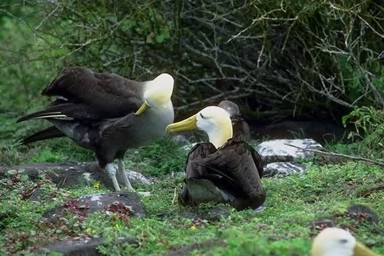

In [ ]:
Image.open(Real_image_path)

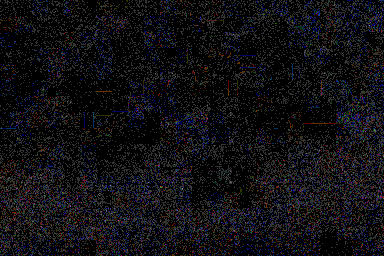

In [ ]:
ela_image(Real_image_path)

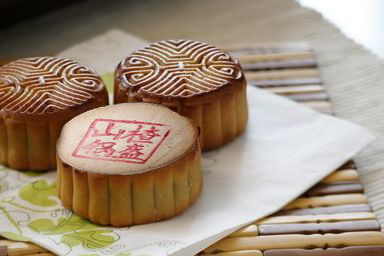

In [ ]:
Image.open(Fake_image_path)

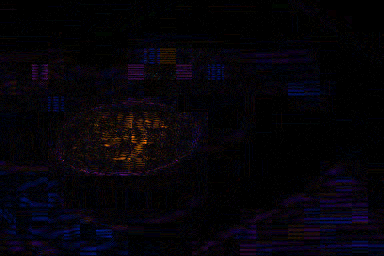

In [ ]:
ela_image(Fake_image_path)

In [ ]:
image_size=(128,128)

In [ ]:
def preprocessing(image_path):
    return np.array(ela_image(image_path).resize(image_size)).flatten()/255

In [ ]:
import numpy as np
preprocessing(Fake_image_path)

array([0.        , 0.        , 0.        , ..., 0.01176471, 0.01960784,
       0.08235294])

In [ ]:
X=[]
Y=[]

In [ ]:
import random
path = '/content/CASIA2/Au'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(1)
random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 2. Skipping tag 41487
  " Skipping tag %s" % (size, len(data), tag)
/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 8 bytes but only got 0. Skipping tag 41988
  " Skipping tag %s" % (size, len(data), tag)


2100 2100


In [ ]:
path = '/content/CASIA2/Tp'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(preprocessing(full_path))
            Y.append(0)
print(len(X), len(Y))

4164 4164


In [ ]:
from keras.utils.np_utils import to_categorical
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 128, 128, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_val,Y_train,Y_val=train_test_split(X,Y,test_size=0.2,random_state=10)
X = X.reshape(-1,1,1,1)
print(len(X_train), len(Y_train))
print(len(X_val), len(Y_val))

3331 3331
833 833


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
def CNN():
    model = Sequential()
    model.add(Conv2D(filters=128,kernel_size=(5,5),activation='relu',input_shape=(128,128,3)))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=256,kernel_size=(5,5),activation='relu'))
    model.add(AveragePooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=64,activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(units=16,activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(units=2,activation='softmax'))
    return model

In [ ]:
model1=CNN()
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 128)     9728      
                                                                 
 average_pooling2d (AverageP  (None, 62, 62, 128)      0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 256)       819456    
                                                                 
 average_pooling2d_1 (Averag  (None, 29, 29, 256)      0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 215296)            0         
                                                                 
 dense (Dense)               (None, 64)                1

In [ ]:
epochs = 30
batch_size = 32
init_lr = 1e-4
optimizer = Adam(lr = init_lr, decay = init_lr/epochs)
model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
  history = model1.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs= 10, batch_size= 32)

Epoch 1/10
105/105 [==============================] - 8s 76ms/step - loss: 0.1672 - accuracy: 0.9622 - val_loss: 0.1277 - val_accuracy: 0.9604
Epoch 2/10
105/105 [==============================] - 8s 73ms/step - loss: 0.1620 - accuracy: 0.9685 - val_loss: 0.1296 - val_accuracy: 0.9664
Epoch 3/10
105/105 [==============================] - 8s 79ms/step - loss: 0.1644 - accuracy: 0.9613 - val_loss: 0.1570 - val_accuracy: 0.9496
Epoch 4/10
105/105 [==============================] - 8s 74ms/step - loss: 0.1579 - accuracy: 0.9655 - val_loss: 0.1196 - val_accuracy: 0.9640
Epoch 5/10
105/105 [==============================] - 8s 74ms/step - loss: 0.1537 - accuracy: 0.9646 - val_loss: 0.1648 - val_accuracy: 0.9460
Epoch 6/10
105/105 [==============================] - 8s 73ms/step - loss: 0.1447 - accuracy: 0.9697 - val_loss: 0.1285 - val_accuracy: 0.9604
Epoch 7/10
105/105 [==============================] - 8s 73ms/step - loss: 0.1357 - accuracy: 0.9742 - val_loss: 0.1233 - val_accuracy: 0.9652

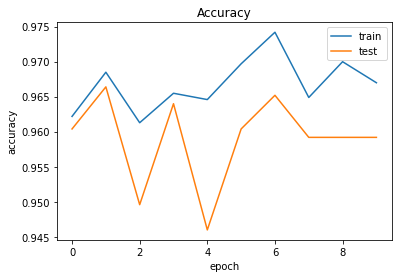

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

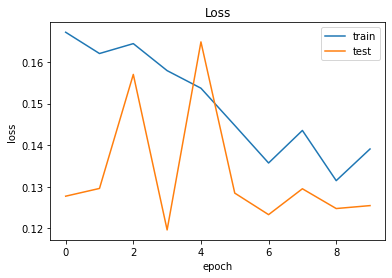

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


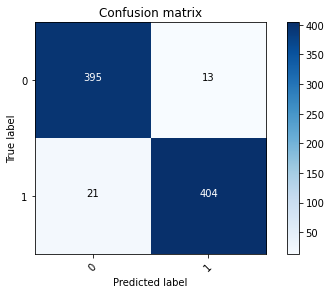

In [ ]:
Y_pred = model1.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(Y_val,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [ ]:
class_names = ['fake', 'real']
real_image_path = '/content/CASIA2/Au/Au_ani_00001.jpg'
image = preprocessing(real_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model1.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Image is : {class_names[y_pred_class]} With presentage of : {np.amax(y_pred) * 100:0.2f}')

Image is : real With presentage of : 99.95


In [ ]:
import tensorflow as tf
converter=tf.lite.TFLiteConverter.from_keras_model(model1)
tflite_model=converter.convert()
with open("ForgeryDetector.tflite",'wb' ) as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmp_9ej_ddm/assets
